# coolest DMBEM Project

## Code Structure

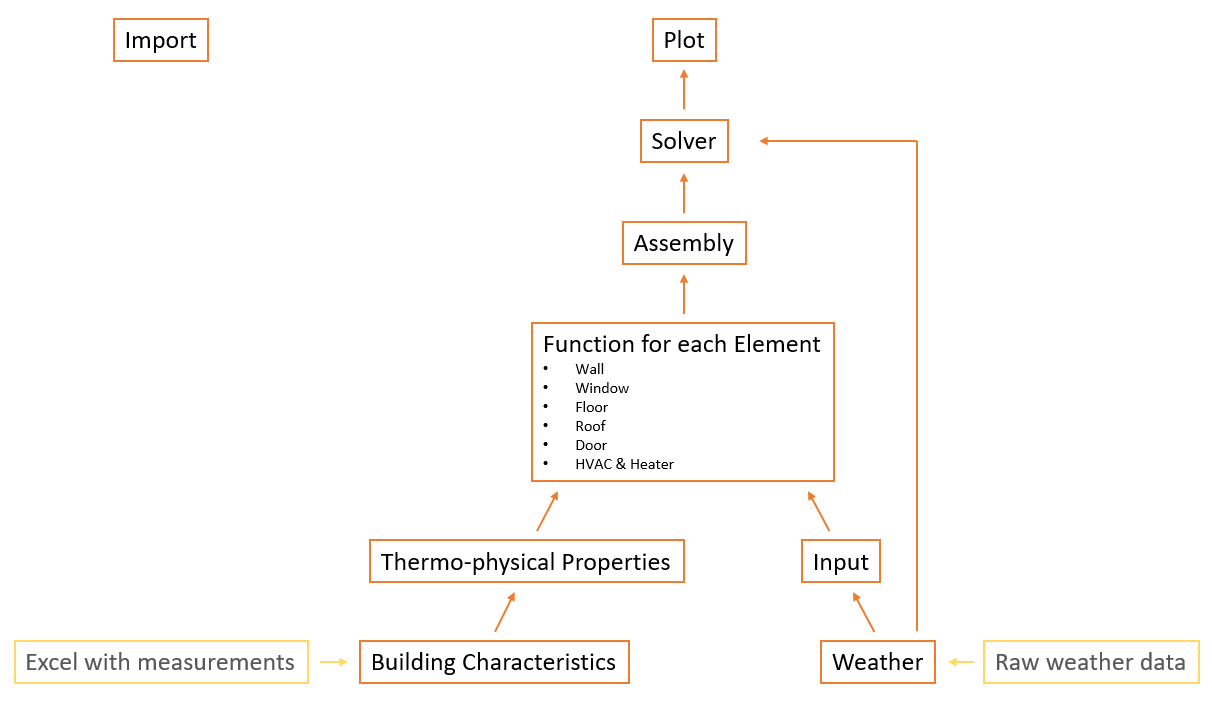

### Excel file with measurements (C)


### Thermophysical Properties (L)

lines 29-70 of t04.py

Materials:
- concrete
- insulation
- glass
- tiles (roof)
- air

Properties:
- density kg/m³
- specific heat J/kg.K
- conductivity W/m.K
- long wave emissivity
- short wave transmittance
- absorptivity
- albedo

Input/Return:
- Input: materials needed
- Return: data frame with properties of the selected materials


In [5]:
import pandas as pd

 thphp = {'Density': [2300, 55, 2500, 1.2, '-'],         # kg/m³
          'Specific_Heat': [880, 1210, 750, 1000, '-'],  # J/kg.K
          'Conductivity': [1.4, 0.027, 1.4, '-', 0.52],  # W/m.K
          'LW_Emissivity': [0.9, 0, 0.9, 0, 0.91],
          'SW_Transmittance': [0, 0, 0.83, 1, 0],
          'SW_Absorptivity': [0.25, 0.25, 0.1, 0, 0.64],
          'Albedo': [0.75, 0.75, 0.07, 0, 0.36]}         # albedo + SW transmission + SW absorptivity = 1

    thphp = pd.DataFrame(thphp, index=['Concrete', 'Insulation', 'Glass', 'Air', 'Tiles'])
thphp

,Density,Specific Heat,Conductivity,LW Emissivity,SW Transmittance,SW Absorptivity,Albedo
Concrete,2300,880,1.4,0.90,0.00,0.25,0.75
Insulation,55,1210,0.027,0.00,0.00,0.25,0.75
Glass,2500,750,1.4,0.90,0.83,0.10,0.07
Air,1.2,1000,-,0.00,1.00,0.00,0.00
Tiles,-,-,0.52,0.91,0.00,0.64,0.36


### Building Characteristics

lines 23-28 of t04.py

- width
- surface
- azimuth
- slope
- view factor
- volume
- material

### Input

lines 17-21 of t04.py

- kp and dt (17-21)
- set points
- meshes (44)
- mean temp for radiative exchange (66)
- air changes per hour (26)
- convection coefficients W/m² K (68)
- calc: Gv (90)

### Weather

lines 222-235 of t04.py

### Functions for each element (E)

lines 71-180 of t04.py

- Wall
- Window
- Floor
- Roof
- Door
- HVAC & Heater

### Assembly

lines 166-180 of t04.py

### Solver

lines 181-214 and 244-276 of t04.py

### Plot

lines 218-220 and 277-292 of t04.py

### Import and Constants

lines 9-12 of t04.py

- Stefan-Bolzmann constant